In [ ]:
pip install --upgrade wandb

In [ ]:
!wandb login dd888f73500a67fc53f9191092b22f3946ac0e02

In [ ]:
# Init wandb
import wandb

wandb.init(project="assignment-1", entity="ravi-kumar")

# Declare Hyperparameters


#Question 1

In [ ]:
def q1_plot_samples():
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

  labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]
  p_images, p_labels= [], []

  for i in range(len(x_train)):
    if len(p_labels) == 10:
      break
    if labels[y_train[i]] not in p_labels:
      p_images.append(x_train[i])
      p_labels.append(labels[y_train[i]])

  wandb.log({ "Class Examples": [ wandb.Image(img, caption=label) for img, label in zip(p_images, p_labels)] })

In [ ]:
q1_plot_samples()

# Imports

In [ ]:
from keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score

# Model Class

In [32]:
class FFNNetwork:

    def __init__(self, input_size, output_size=1, hidden_layers=[2], init_func='xavier', act_func='sigmoid', loss_func='ce'):

      # Initializing Network Parameters
      self.x= input_size
      self.y= output_size
      self.h= len(hidden_layers)
      self.init_func= init_func
      self.act_func= act_func
      self.loss_func= loss_func
      self.sizes= [self.x] + hidden_layers + [self.y]
      self.W= {}
      self.B= {}
      np.random.seed(0)

      # He Initialization
      if self.init_func=='he':
        for i in range(self.h+1):
          self.W[i+1]=np.random.randn(self.sizes[i], self.sizes[i+1]) * np.sqrt(2 / self.sizes[i-1])
          self.B[i+1]=np.random.randn(1, self.sizes[i+1])
      
      # Xavier Initialization
      elif self.init_func=='xavier':
        for i in range(self.h+1):
          self.W[i+1]=np.random.randn(self.sizes[i], self.sizes[i+1]) * np.sqrt(1 / self.sizes[i-1])
          self.B[i+1]=np.random.randn(1, self.sizes[i+1])

      # Zero Initialization
      elif self.init_func=='zero':
        for i in range(self.h+1):
          self.W[i+1]=np.zeros((self.sizes[i], self.sizes[i+1]))
          self.B[i+1]=np.zeros((1, self.sizes[i+1]))
      
      # Random Initialization
      else:
        for i in range(self.h+1):
          self.W[i+1]=np.random.randn(self.sizes[i], self.sizes[i+1])
          self.B[i+1]=np.random.randn(1, self.sizes[i+1])

    def perceptron(self, x, w, b):
      """ It computes the perceptron output for the inputs passed """
      return np.dot(x, w)+ b

    def activation(self, x):
      """ It computes the activation function used """
      # Using tanh function as the activation function
      if self.act_func == 'tanh':
        return np.tanh(x)
      
      # Using ReLU function as the activation function
      elif self.act_func == 'relu':
        return np.maximum(0, x)

      # Using sigmoid function as the activation function
      else:
        return 1.0/(1.0 + np.exp(-x))

    def grad_activation(self, x):
      """ It computes the gradient of activation function used """
      # Gradient of tanh function
      if self.act_func == 'tanh':
        return (1 - np.square(x))
      
      # Gradient of ReLU function
      elif self.act_func == 'relu':
        return (1.0 * (x>0))

      # Gradient of sigmoid function
      else:
        return x * (1-x)
      

    def softmax(self, y):
      """ It computes the softmax of input array passed """
      max=np.max(y)
      exps=np.exp(y-max)
      return np.exp(y-max)/np.sum(exps)

    def forward_pass(self, x):
      """ It runs a forward pass of Feed Forward Neural Network """
      self.A={}
      self.H={}
      self.H[0]= x
      
      for i in range(self.h+1):
        self.A[i+1]=np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
        self.H[i+1]=self.activation(self.A[i+1])
      self.H[self.h+1]=self.softmax(self.A[self.h+1])
      return self.H[self.h+1]

    def grad(self, x, y):
      """ It computes the gradient using backpropgation """
      
      L=self.h+1
      self.forward_pass(x)

      self.dW={}
      self.dB={}
      self.dA={}
      self.dH={}

      if self.loss_func=='mse':
        self.dA[L]=(self.H[L]-y) * self.H[L] * (1-self.H[L])
      else:
        self.dA[L]=(self.H[L]-y)

      for k in range(L, 0, -1):
        self.dW[k]=np.matmul(self.H[k-1].T, self.dA[k])
        self.dB[k]=self.dA[k]
        self.dH[k-1]=np.matmul(self.dA[k], self.W[k].T)
        self.dA[k-1]=np.multiply(self.dH[k-1], self.grad_activation(self.H[k-1]))

    def predict(self, X):
      """ It predicts the output for the inputs passed """
      preds=[]
      for x in X:
        preds.append(self.forward_pass(x)) 
      return np.array(preds).squeeze()

    def fit(self, inputs, output_labels, epochs=1, lr=0.001, weight_decay=0, display_loss=False, display_accuracy=False, opt_algo='adam', batch_size=128, gamma=0.9, beta=0.9, beta1=0.9, beta2=0.999, epsi=1e-8):
      """ It trains the Neural Netword """
      
      x_train, x_val, y_train, y_val= train_test_split(inputs, output_labels, test_size=0.1, random_state=1)

      accuracy, val_accuracy, loss, val_loss= {}, {}, {}, {}
      vW, vB, best_W, best_B= {}, {}, {}, {}
      max_accuracy, max_val_accuracy = 0, 0
      for i in range(self.h+1):
        vW[i+1]=np.zeros((self.sizes[i], self.sizes[i+1]))
        vB[i+1]=np.zeros((1, self.sizes[i+1]))

      m=inputs.shape[2]

      for e in tqdm(range(epochs), total=epochs, unit="epoch"):
        dW, dB= {}, {}

        for i in range(self.h+1):
          dW[i+1]=np.zeros((self.sizes[i], self.sizes[i+1]))
          dB[i+1]=np.zeros((1, self.sizes[i+1]))

        # Gradient Descent/ Batch Gradient Descent/ Vanilla Gradient Descent
        if opt_algo=='gd' or opt_algo=='bgd' or opt_algo=='vgd': 

          for x, y in zip(x_train, y_train):
            self.grad(x, y)
            for i in range(self.h+1):
              if l2_regularisation:
                dW[i+1]+=self.dW[i+1] + weight_decay * self.W[i+1]
              else:
                dW[i+1]+=self.dW[i+1]
              dB[i+1]+=self.dB[i+1]

          for i in range(self.h+1):
            self.W[i+1]-= lr* (dW[i+1])/m
            self.B[i+1]-= lr* (dB[i+1])/m

        # Stochastic Gradient Descent
        elif opt_algo=='sgd':
          
          sample_count= 0
          for x, y in zip(x_train, y_train):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+= self.dW[i+1] + weight_decay * self.W[i+1]
              dB[i+1]+= self.dB[i+1]

              if sample_count % batch_size == 0:
                self.W[i+1]-= lr*dW[i+1]/batch_size
                self.B[i+1]-= lr*dB[i+1]/batch_size

        # Momentum Based Gradient Descent
        elif opt_algo=='momentum':

          sample_count=0
          for x, y in zip(x_train, y_train):
            self.grad(x, y)
            for i in range(self.h+1): 
              dW[i+1]+= self.dW[i+1] + weight_decay * self.W[i+1]
              dB[i+1]+= self.dB[i+1]
            
            sample_count+=1
            if sample_count % batch_size == 0:
              for i in range(self.h+1):
                vW[i+1]= (gamma * vW[i+1] + lr*dW[i+1])/batch_size
                vB[i+1]= (gamma * vB[i+1] + lr*dB[i+1])/batch_size
                self.W[i+1]-= vW[i+1]
                self.B[i+1]-= vB[i+1]

        # Nestrov Accelerated Gradient Descent
        elif opt_algo=='nesterov':

          sample_count=0
          for x, y in zip(x_train, y_train):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+= self.dW[i+1] + weight_decay * self.W[i+1]
              dB[i+1]+= self.dB[i+1]

            if sample_count % batch_size == 0:
              tW, tB= {}, {}
              for i in range(self.h+1):
                tW[i+1]= self.W[i+1] - gamma * vW[i+1]
                tB[i+1]= self.B[i+1] - gamma * vB[i+1]
                self.W[i+1]= tW[i+1]
                self.B[i+1]= tB[i+1]

              self.grad(x, y)
              for i in range(self.h+1):
                vW[i+1]= gamma * vW[i+1] + lr * self.dW[i+1]
                vB[i+1]= gamma * vB[i+1] + lr * self.dB[i+1]
                self.W[i+1]= tW[i+1] - vW[i+1]
                self.B[i+1]= tB[i+1] - vB[i+1]
                               
        # RMSProp Gradient Descent
        elif opt_algo=='rmsprop':

          sample_count=0
          for x, y in zip(x_train, y_train):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+= self.dW[i+1] + weight_decay * self.W[i+1]
              dB[i+1]+= self.dB[i+1]

            if sample_count % batch_size == 0:

              for i in range(self.h+1):
                vW[i+1]= beta * vW[i+1] + (1-beta) * np.power(dW[i+1], 2)
                vB[i+1]= beta * vB[i+1] + (1-beta) * np.power(dB[i+1], 2)
                self.W[i+1]-= (lr/np.sqrt(vW[i+1] + epsi)) * dW[i+1]
                self.B[i+1]-= (lr/np.sqrt(vB[i+1] + epsi)) * dB[i+1]                

        # Adam Gradient Descent
        elif opt_algo=='adam':

          sample_count=0
          for x, y in zip(x_train, y_train):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+= self.dW[i+1] + weight_decay * self.W[i+1]
              dB[i+1]+= self.dB[i+1]

            if sample_count % batch_size == 0:
              mW, mB= {}, {}
              for i in range(self.h+1):
                mW[i+1]= np.zeros(dW[i+1].shape)
                mB[i+1]= np.zeros(dB[i+1].shape)
                mW[i+1]= beta1 * mW[i+1] + (1 - beta1) * dW[i+1]
                mB[i+1]= beta1 * mB[i+1] + (1 - beta1) * dB[i+1]

                vW[i+1]= beta2 * vW[i+1] + (1 - beta2) * np.power(dW[i+1], 2)
                vB[i+1]= beta2 * vB[i+1] + (1 - beta2) * np.power(dB[i+1], 2)

                mW[i+1]= (1.0/(1.0- np.power(beta1 , sample_count))) * mW[i+1]
                mB[i+1]= (1.0/(1.0- np.power(beta1 , sample_count))) * mB[i+1]
                vW[i+1]= (1.0/(1.0- np.power(beta2 , sample_count))) * vW[i+1] 
                vB[i+1]= (1.0/(1.0- np.power(beta2 , sample_count))) * vB[i+1]

                self.W[i+1]-= (lr/np.sqrt(vW[i+1] + epsi)) * mW[i+1]
                self.B[i+1]-= (lr/np.sqrt(vB[i+1] + epsi)) * mB[i+1]

        # Nadam Gradient Descent
        elif opt_algo=='nadam':

          sample_count=0
          for x, y in zip(x_train, y_train):
            self.grad(x, y)
            sample_count+=1
            for i in range(self.h+1): 
              dW[i+1]+= self.dW[i+1] + weight_decay * self.W[i+1]
              dB[i+1]+= self.dB[i+1]

            if sample_count % batch_size == 0:
              mW, mB= {}, {}
              for i in range(self.h+1):
                mW[i+1]= np.zeros(dW[i+1].shape)
                mB[i+1]= np.zeros(dB[i+1].shape)
                mW[i+1]= beta1 * mW[i+1] + (1-beta1) * dW[i+1]
                mB[i+1]= beta1 * mB[i+1] + (1-beta1) * dB[i+1]

                vW[i+1]= beta2 * vW[i+1] + (1-beta2) * np.power(dW[i+1], 2)
                vB[i+1]= beta2 * vB[i+1] + (1-beta2) * np.power(dB[i+1], 2)
                
                mW[i+1]= mW[i+1] / (1- np.power(beta1 , sample_count))
                mB[i+1]= mB[i+1] / (1- np.power(beta1 , sample_count))
                vW[i+1]= vW[i+1] / (1- np.power(beta2 , sample_count))
                vB[i+1]= vB[i+1] / (1- np.power(beta2 , sample_count))
                xW, xB= {}, {}
                xW[i+1]= beta1 * mW[i+1] + (1-beta1) * dW[i+1] / (1- np.power(beta1, sample_count))
                xB[i+1]= beta1 * mB[i+1] + (1-beta1) * dB[i+1] / (1- np.power(beta1, sample_count))
                self.W[i+1]-= ((lr/np.sqrt(vW[i+1] + epsi)) * xW[i+1])
                self.B[i+1]-= ((lr/np.sqrt(vB[i+1] + epsi)) * xB[i+1])

        # Calculating Loss and Accuracy
        y_preds=self.predict(x_train)
        y_val_preds=self.predict(x_val)
        if self.loss_func=='mse':
          loss[e]= mean_squared_error(y_train, y_preds)
          val_loss[e]= mean_squared_error(y_val, y_val_preds)
        else:
          loss[e]= log_loss(y_train, y_preds)
          val_loss[e]= log_loss(y_val, y_val_preds)

        accuracy[e]= accuracy_score(np.argmax(y_preds, axis=1), np.argmax(y_train, axis=1))
        val_accuracy[e]= accuracy_score(np.argmax(y_val_preds, axis=1), np.argmax(y_val, axis=1))

        if accuracy[e] > max_accuracy:
          max_accuracy= accuracy[e]
          max_val_accuracy= val_accuracy[e]
          best_W=self.W.copy()
          best_B=self.B.copy()
        
        # wandb.log({ 'mnist_accuracy': accuracy[e]})
        # wandb.log({ 'epoch': e, 'loss': loss[e], 'val_loss': val_loss[e], 'accuracy': accuracy[e], 'val_accuracy': val_accuracy[e]})

      # Plotting Loss
      if display_accuracy:
        print('Train Accuracy : ', max_accuracy)
        print('Validation Accuracy : ', max_val_accuracy)

      # Plotting Loss
      if display_loss:
        plt.plot(np.asarray(list(loss.values())))
        plt.xlabel("Epoch")
        plt.ylabel("Mean Squared Loss")
        plt.show()


# Wandb Hyperparameter Tunning

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [ 5, 10]
        },
        'hidden_layers': {
            'values': [3, 4, 5]
        },
        'hidden_layer_size': {
            'values': [32, 64, 128]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'initialisation': {
            'values': ['random', 'xavier']
        },        
        'activation': {
            'values': ['sigmoid', 'tanh', 'relu']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ravi-kumar", project="assignment-1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: wf3zsbpf
Sweep URL: https://wandb.ai/ravi-kumar/assignment-1/sweeps/wf3zsbpf


In [ ]:
def train():
  config_defaults = {
        'epochs': 5,
        'hidden_layers': 3,
        'hidden_layer_size': 32,
        'weight_decay': 0,
        'learning_rate': 1e-3,
        'optimizer': 'adam',
        'batch_size': 64,
        'initialisation': 'xavier',        
        'activation': 'sigmoid'
    }
  wandb.init(config=config_defaults)
  config= wandb.config
  hl= [config.hidden_layer_size for h in range(config.hidden_layers)]
  ffnn= FFNNetwork(x_train.shape[2], output_size= y_train.shape[1], hidden_layers=hl, act_func=config.activation, init_func=config.initialisation)
  ffnn.fit(x_train, y_train, display_loss=True, opt_algo=config.optimizer, weight_decay=config.weight_decay, epochs=config.epochs, lr=config.learning_rate, batch_size=config.batch_size)

In [ ]:
wandb.agent(sweep_id, train)

# Method for preprocessing image dataset

In [ ]:
def load_fashion_mnist_data(split_val=False):

    """ Prepares image data for muti-class classification model """

    # Load data
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # Flaten image data
    x_train= x_train.reshape(x_train.shape[0], 1, x_train.shape[1] * x_train.shape[2])
    x_test= x_test.reshape(x_test.shape[0], 1, x_test.shape[1] * x_test.shape[2])

    # Convert from integers to floats
    x_train_f = x_train.astype(np.float64)
    x_test_f = x_test.astype(np.float64)

    # Normalize
    x_train_norm= x_train_f/255.0
    x_test_norm= x_test_f/255.0

    # Encode output labels using one hot encoding
    encoder=OneHotEncoder()
    y_train_encoded= encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
    y_test_encoded= encoder.transform(y_test.reshape(-1, 1)).toarray()

    if split_val:
      x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size=0.1, random_state=1)
      return x_train_norm, x_val, x_test_norm, y_train_encoded, y_val, y_test_encoded
    else:
      return x_train_norm, x_test_norm, y_train_encoded, y_test_encoded

In [ ]:
def load_mnist_data(split_val=False):

    """ Prepares image data for muti-class classification model """

    # Load data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Flaten image data
    x_train= x_train.reshape(x_train.shape[0], 1, x_train.shape[1] * x_train.shape[2])
    x_test= x_test.reshape(x_test.shape[0], 1, x_test.shape[1] * x_test.shape[2])

    # Convert from integers to floats
    x_train_f = x_train.astype(np.float64)
    x_test_f = x_test.astype(np.float64)

    # Normalize
    x_train_norm= x_train_f/255.0
    x_test_norm= x_test_f/255.0

    # Encode output labels using one hot encoding
    encoder=OneHotEncoder()
    y_train_encoded= encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
    y_test_encoded= encoder.transform(y_test.reshape(-1, 1)).toarray()

    if split_val:
      x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size=0.1, random_state=1)
      return x_train_norm, x_val, x_test_norm, y_train_encoded, y_val, y_test_encoded
    else:
      return x_train_norm, x_test_norm, y_train_encoded, y_test_encoded

# Training and Testing Model for fashion_mnist dataset

## Loading Data

In [ ]:
x_train, x_test, y_train, y_test= load_fashion_mnist_data()

## Training Model

In [ ]:
ffnn=FFNNetwork(x_train.shape[2], output_size= y_train.shape[1], hidden_layers=[128, 128, 128], act_func='tanh', loss_func='ce')
ffnn.fit(x_train, y_train, weight_decay=0.0005, display_loss=True, display_accuracy=True, batch_size=32, opt_algo='rmsprop', epochs=10, lr=0.0001)

## Testing Model

In [35]:
y_preds=ffnn.predict(x_test)
y_preds=np.argmax(y_preds, axis=1)
test=np.argmax(y_test, axis=1)
accuracy_score(y_preds, test)

0.8481

# Training and Testing Model for mnist dataset

## Loading Data

In [27]:
x_train, x_test, y_train, y_test= load_mnist_data()

## Training Model

In [ ]:
ffnn=FFNNetwork(x_train.shape[2], output_size= y_train.shape[1], hidden_layers=[128, 128, 128], act_func='relu', loss_func='ce')
ffnn.fit(x_train, y_train, weight_decay=0.0005, display_loss=True, display_accuracy=True, batch_size=64, opt_algo='momentum', epochs=10, lr=0.001)

## Testing Model

In [ ]:
y_preds=ffnn.predict(x_test)
y_preds=np.argmax(y_preds, axis=1)
test=np.argmax(y_test, axis=1)
accuracy_score(y_preds, test)

0.8267

# Plotting Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

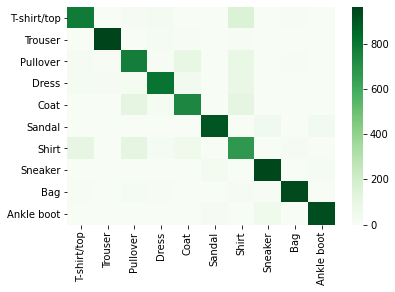

In [37]:
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]
cm=confusion_matrix(test, y_preds)
figure=sn.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels, cmap='Greens')
wandb.log({ 'confusion_matrix': wandb.Image(figure) })
# wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None, y_true=test, preds=y_preds, class_names=labels, title='Confusion Matrix')})
# wandb.log({'confusion_matrix_heatmap': wandb.plots.HeatMap(labels, labels, cm, show_text=False)})